# Zadania domowe

W ramach tego modułu do zdobycia są 4 punkty. 

> **Uwaga**: Zdanie 4.1 można wykonać conajwyżej 2 razy u różnych dostawców. Pozostałe zadania można wykonać tylko raz.

> **Uwaga**: Zadanie 4.2 można wykonać tylko u dostawców oferujących usługę automatycznego skalowania (AWS, Azure).

> **Uwaga**: Łącznie można wykonać zadania za znacznie więcej niż dostępnych 4 punktów. Uzyskany wynik zostanie jednak obcięty do wartości maksymalnej.


## Zadanie 4.1 (2 punkty)
Celem tego zadania jest przedstawienie rozwiązania tylu *load balancer*.

Zadanie polega na uruchomieniu prostego webserwisu w infrastrukturze chmurowej w wielu instancjach jednocześnie z zapewnieniem pojedynczego punktu dostępowego, który będzie dynamicznie delegował żądania do dostępnych instancji.

Webserwis udostępnia jeden endpoint HTTP `/factors/<liczba>`, zwracający odpowiedź w formacie `JSON`, która zawiera listę czynników pierwszych liczby zawartej w żądaniu. Przesłana w żądaniu liczba musi być liczbą całkowitą, większą od 1, w przeciwnym razie serwis zwraca kod błędu 400. Nie ma ograniczenia na wielkość danych wejściowych. Dla dostatecznie dużej liczby czas oczekiwania na odpowiedź może być bardzo długi.

Przykładowo dla zapytania
```bash
curl <adres_serwera>:<port>/factors/10
```
odpowiedź to
```json
[2, 5]
```

Dany jest program w postaci binarnej (skompilowanej na architekturę `amd64`, jednowątkowy), realizujący ten webserwis na porcie 8080.

### Sposób sprawdzania zadania
Zadanie będzie sprawdzane półautomatycznie. Do skryptu sprawdzającego należy podać adres URL webserwisu. Sprawdzarka będzie w kilku wątkach jednocześnie wysyłała żądania pod wskazany adres. Jeden wątek (t0) wysyłać będzie małe liczby, dla których rozkład będzie zajmował poniżej sekundy. W tym samym czasie kolejne wątki, dodawane w regularnych odstępach czasu, będą wysyłały bardzo duże liczby, dla których rozkład na czynniki pierwsze będzie wymagał przynajmniej kilku sekund. Zadanie zostanie zaliczone wtedy, gdy wątek wysyłający małe liczby (t0) będzie otrzymywać odpowiedzi z serwera szybko, bez oczekiwania na rozłożenie większych liczb.

Poniżej przykładowe wykresy dla różnych konfiguracji:

* brak równoważenia obciążenia (1 worker) 

    ![brak równoważenia obciążenia (1 worker)](obrazy/Z01_1worker.png)
* równoważenie obciążenia bez skalowania (2 workery) 

    ![równoważenie obciążenia bez skalowania (2 workery)](obrazy/Z01_2workers.png)
* równoważenie obciążenia  (4 workery) 

    ![równoważenie obciążenia  (4 workery) ](obrazy/Z01_4workers.png)
* równoważenie obciążenia bez skalowania (5 workerów) 

    ![równoważenie obciążenia bez skalowania (5 workerów)](obrazy/Z01_5workers.png)

In [5]:
import requests
import random
import math
import time
import threading
import logging
logging.getLogger().setLevel(logging.INFO)


API_URL="http://localhost:8080"


UNIT = 5.0 # secs

# Pre generated primes
first_primes_list = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29,
                     31, 37, 41, 43, 47, 53, 59, 61, 67,
                     71, 73, 79, 83, 89, 97, 101, 103,
                     107, 109, 113, 127, 131, 137, 139,
                     149, 151, 157, 163, 167, 173, 179,
                     181, 191, 193, 197, 199, 211, 223,
                     227, 229, 233, 239, 241, 251, 257,
                     263, 269, 271, 277, 281, 283, 293,
                     307, 311, 313, 317, 331, 337, 347, 349]


def nBitRandom(n):
    return random.randrange(2**(n-1)+1, 2**n - 1)
 
def getLowLevelPrime(n):
    '''Generate a prime candidate divisible
    by first primes'''
    while True:
        # Obtain a random number
        pc = nBitRandom(n)
 
         # Test divisibility by pre-generated
         # primes
        for divisor in first_primes_list:
            if pc % divisor == 0 and divisor**2 <= pc:
                break
        else: return pc
 
def isMillerRabinPassed(mrc):
    '''Run 20 iterations of Rabin Miller Primality test'''
    maxDivisionsByTwo = 0
    ec = mrc-1
    while ec % 2 == 0:
        ec >>= 1
        maxDivisionsByTwo += 1
    assert(2**maxDivisionsByTwo * ec == mrc-1)
 
    def trialComposite(round_tester):
        if pow(round_tester, ec, mrc) == 1:
            return False
        for i in range(maxDivisionsByTwo):
            if pow(round_tester, 2**i * ec, mrc) == mrc-1:
                return False
        return True
 
    # Set number of trials here
    numberOfRabinTrials = 20
    for i in range(numberOfRabinTrials):
        round_tester = random.randrange(2, mrc)
        if trialComposite(round_tester):
            return False
    return True
 
def random_large_prime(bits):
    while True:
        prime_candidate = getLowLevelPrime(bits)
        if not isMillerRabinPassed(prime_candidate):
            continue
        else:
            return prime_candidate

def thread_function(i, fast, timeout):
    start = time.time()

    c = 5 # bits: 20: 200ms; 21: 350ms; 22: 700ms  23: 1.5s; 25: 6s; 26: 10s; 27: 24s
    bits = 19 if fast else 23
    last_report = time.time()
    processing_time = 0.0
    reqs = 0
    while True:
        iter_start = time.time()
        if iter_start - start > timeout:
            logging.info("Thread: %d\treqs: %d\tmean time: %.3fs\t%s"%(i, reqs, processing_time/reqs if reqs>0 else 0.0, "fast\t" if fast else ""))
            results[i][iter_start] = processing_time/reqs if reqs>0 else 0.0
            return
        if iter_start - last_report > UNIT/2:
            if len(results[i])%2 == 0:
                logging.info("Thread: %d\treqs: %d\tmean time: %.3fs\t%s"%(i, reqs, processing_time/reqs if reqs>0 else 0.0, "fast\t" if fast else ""))
            results[i][iter_start] = processing_time/reqs if reqs>0 else 0.0
            processing_time = 0.0
            reqs = 0
            last_report=iter_start

        factors = [random_large_prime(bits) for i in range(c)]
        factors.sort()
        n=math.prod(factors)

        r = requests.get(API_URL+'/factors/%d'%(n))
        if r.status_code != 200:
            logging.error("wrong status code from webservice")
        else:
            result = r.json()
            if result != factors:
                logging.error("Wrong factors")

        processing_time+=time.time() - iter_start
        reqs+=1
        time.sleep(0.5)

START = time.time()
slow_threads = 4

results = [ {} for i in range(slow_threads+1)]

t0 = threading.Thread(target=thread_function, args=(0, True, (5 + slow_threads*3) * UNIT))
t0.start()
time.sleep(2 * UNIT)
for i in range(slow_threads):
    t = threading.Thread(target=thread_function, args=(i+1, False, (slow_threads-i) * 3 * UNIT))
    t.start()
    time.sleep(2 * UNIT)

t0.join()

INFO:root:Thread: 0	reqs: 5	mean time: 0.096s	fast	
INFO:root:Thread: 0	reqs: 5	mean time: 0.096s	fast	
INFO:root:Thread: 1	reqs: 2	mean time: 1.403s	
INFO:root:Thread: 0	reqs: 5	mean time: 0.098s	fast	
INFO:root:Thread: 0	reqs: 5	mean time: 0.096s	fast	
INFO:root:Thread: 1	reqs: 2	mean time: 1.539s	
INFO:root:Thread: 2	reqs: 2	mean time: 2.062s	
INFO:root:Thread: 0	reqs: 4	mean time: 0.194s	fast	
INFO:root:Thread: 1	reqs: 1	mean time: 2.307s	
INFO:root:Thread: 0	reqs: 4	mean time: 0.149s	fast	
INFO:root:Thread: 2	reqs: 2	mean time: 1.845s	
INFO:root:Thread: 3	reqs: 1	mean time: 2.299s	
INFO:root:Thread: 0	reqs: 4	mean time: 0.196s	fast	
INFO:root:Thread: 1	reqs: 2	mean time: 2.098s	
INFO:root:Thread: 3	reqs: 2	mean time: 1.765s	
INFO:root:Thread: 2	reqs: 1	mean time: 2.092s	
INFO:root:Thread: 0	reqs: 4	mean time: 0.164s	fast	
INFO:root:Thread: 4	reqs: 1	mean time: 2.503s	
INFO:root:Thread: 1	reqs: 1	mean time: 2.268s	
INFO:root:Thread: 2	reqs: 1	mean time: 2.200s	
INFO:root:Thread: 3	

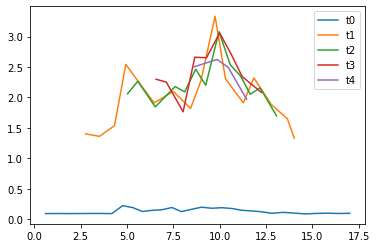

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
mu = 0
std = 1
for i, result in enumerate(results):
    x = [(x - START)/UNIT for x in result.keys()]
    y = result.values()
    plt.plot(x, y, label="t%d"%(i,))

plt.legend()
plt.show()

## Zadanie 4.2 (2 punkty + 2 punkty za 4.1)

Zadanie polega na rozbudowaniu rozwiązania 4.1 o usługę automatycznego skalowania. Webserwis w wariancie początkowym powinien dysponować 2 instancjami (jak w zadaniu 4.1). Jednak w przypadku wzrostu ilości żądań powinien automatycznie przeskalować się poprzez dodanie nowych instancji (do maksymalnie 5).

### Sposób sprawdzania zadania
Zadanie będzie sprawdzane półautomatycznie z wykorzystaniem skryptu z zadania poprzedniego.

> **Wskazówka**: Mechaznim autoamtycznego skalowania potrzebuje trochę czasu aby zadziałać, konieczne może okazać się zwiększenie wartości zmiennej UNIT z 5 sekund do 30-60 sekund.

## Zadanie 4.3 (2 punkty, wymaga zaliczenia zadania 4.1 lub 4.2)
Zautomatyzuj wykonanie zadania 4.1 lub 4.2 tak aby cała infrastruktura (łącznie z zasobami chmurowymi, konfiguracją maszyn i oprogramowania) wykonywana była przez odpowiedni skrypt za pośrednictwem jednej komendy w konsoli. Na koniec swojego działania komenda ma wyświetlać URL dostępowy do webserwisu.

Sam skrypt oraz wszystkie niezbędne pliki (np. cloud-init, pliki konfiguracyjne, itp.) powinny znajdować się na repozytorium Git.

> Uwaga: Pamiętaj aby przygotować stosowną dokumentację (w formacie Markdown w pliku README.md) opisującą konfigurację środowiska wymaganą przez ten skrypt (autoryzacja do platform chmury obliczeniowej, zmienne środowiskowe, itp.). Nie powinna ona jednak być zbyt skomplikowana i wykraczać znacznie poza autoryzację do chmury.

> Wskazówka: Technologia w której przygotowany zostanie skrypt nie jest ograniczona, wymagane jest tylko umożliwienie uruchomienia jej na systemie Linux (np. Ubuntu/Debian) bez potrzeby nadmiernej rekonfiguracji systemu. W przypadku potrzeby skorzystania z niestandardowych narzędzi, zalecane jest skorzystanie z narzędzia Docker, zbudowanie specjalnego obrazu i wykonanie skryptu z jego poziomu.

### Sposób sprawdzania zadania
Zadanie sprawdzane jest ręcznie poprzez sklonowanie repozytorium Git, wykonanie konfiguracji zgodnie z dokumentacją, wywołanie odpowiedniego skryptu i ręczne sprawdzenie czy system został zbudowany zgodnie ze specyfikacją. Skrypt będzie wykonywany w środowisku zapewnionym i skonfigurowanym przez prowadzącego zajęcia. Przykład sposobu wykonania skryptu przez prowadzącego:

```bash
git clone git@git.wmi.amu.edu.pl:s<index>/<repo_name>.git
cd <repo_name>
./deploy.sh
```

Po zakończeniu skryptu deploy, przeprowadzona zostanie procedura sprawdzania zadania 4.1 lub zadania 4.2.

## Zadanie 4.4 (3 punkty)
Zadanie ma na celu uświadomienie różnic w cennikach różnych dostawców usług chmurowych.

> **Wskazówka**: Zadanie można realizować we dwie osoby, obie otrzymują wtedy taką samą ilość punktów.

Zadanie polega na przeanalizowaniu kosztów wdrożenia przykładowego systemu informatycznego u różnych dostawców chmury obliczeniowej. Rozwiązaniem zadania będzie raport przygotowany w formacie PDF porównujący koszt wdrożenia danego systemu w przynajmniej 4 wariantach u przynajmniej dwóch różnych dostawców. Oprócz łącznego kosztu (startowego i miesiecznego) należy porównać też koszt poszczególnych składowych, uwzględnić możliwe promocje (reserved, spot, itp). Zakładamy, że system będzie działał nieprzerwanie przez rok.

**Specyfikacja systemu**

> **Uwaga**: Opisywana specyfikacja dotyczy rzeczywistego systemu informatycznego będącego kopalnią kryptowalut.

1. Główny węzłeł sieci kryptowalutowej. Wymagane przynajmniej 32GB RAM, 8vCPU, 600GB dysku twardego. Wymagania specjalne: bardzo duża wydajność dysku twardego, transfer sieciowy na poziomie 2-3TB/miesiąc.
1. Zapasowy węzeł sieci kryptowalutowej. Wymagane przynajmniej 8GB RAM, 3vCPU, 600GB dysku twardego. Wymagania specjalne: duża wydajność dysku twardego, transfer sieciowy na poziomie 2-3TB/miesiąc.
1. Baza danych Redis. Wymagane przynajmniej 2GB RAM, 2vCPU, 10GB dysku twardego. Wymagania specjalne: wysoka dostępność, brak dostępu do bazy danych uniemożliwia działania wszyskich innych modułów
1. Moduł kopania. Wymagane przynajmniej 4GB RAM, 8vCPU, 10GB dysku twardego. Wymagania specjalne: transfer sieciowy na poziomie 1TB/miesiąc, stały adres IP
1. Moduł API i WWW. Wymagane przynajmniej 4GB RAM, 2vCPU, 10GB dysku twardego.
1. Moduł wypłat. Wymagane przynajmniej 2GB RAM, 1vCPU, 10GB dysku twardego.

Każdy moduł, baza danych oraz węzły powinny działać w odseparowanym środowisku z zachowaniem następująch połączeń:
* wszystkie moduły łączą sie z bazą danych
* moduł kopania łączy się z węzłem głównym i zapasowym
* moduł wypłat łączy się z węzłem zapasowym